# Estimating text loss in The Old Norse fornaldarsögur

This Python notebook is a derivative of the one which accompanies the following publication:

> Mike Kestemont and Folgert Karsdorp, "Het Atlantis van de Middelnederlandse ridderepiek. Een schatting van het tekstverlies met methodes uit de ecodiversiteit". *Spiegel der letteren* (2020).

Adaptation to the current study is still a work in progress. 

All figures and numbers were prepared using the code below. Future updates of the code and data will be managed in an open [Github repository](https://github.com/mikekestemont/chivalric_diversity). The code block below loads all (third-party) packages and modules necessary to run the module. These can be installed from the file `requirements.txt`:

    pip install -r requirements.txt

In [1]:
from functools import partial
from itertools import product

import numpy as np
np.random.seed(12345)
from scipy.special import erfinv
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("tufte.mplstyle")
plt.rcParams["text.usetex"] = False
%matplotlib inline

import scipy.stats as stats
from scipy.special import gammaln

## Data

We load the data from the spreadsheet file `mnl.xlsx`:

In [2]:
mnl = pd.read_excel('mnl.xlsx', header=None, names=('text', 'witness'))
mnl.head(10)

,text,witness
0,Af Upplendinga konungum,"Den Arnamagnæanske Samling, Copenhagen, AM 544..."
1,Áns saga bogsveigis,"Stofnun Árna Magnússonar í íslenskum fræðum, R..."
2,Ásmundar saga kappabana,"Stofnun Árna Magnússonar í íslenskum fræðum, R..."
3,Ásmundar saga kappabana,"Kungliga biblioteket, Stockholm, Perg. 4to nr 7"
4,Bósa saga ok Herrauðs,"Stofnun Árna Magnússonar í íslenskum fræðum, R..."
5,Bósa saga ok Herrauðs,"Stofnun Árna Magnússonar í íslenskum fræðum, R..."
6,Bósa saga ok Herrauðs,"Stofnun Árna Magnússonar í íslenskum fræðum, R..."
7,Bósa saga ok Herrauðs,"Stofnun Árna Magnússonar í íslenskum fræðum, R..."
8,Egils saga einhenda ok Ásmundar berserkjabana,"Stofnun Árna Magnússonar í íslenskum fræðum, R..."
9,Egils saga einhenda ok Ásmundar berserkjabana,"Stofnun Árna Magnússonar í íslenskum fræðum, R..."


We are only interested in the count data, i.e. the number of witnesses per text (the technical term is "abundance data").

In [3]:
mnl.groupby('text').size().sort_values(ascending=False).head()

text
Hrólfs saga Gautrekssonar     8
Örvar-Odds saga               6
Norna-Gests þáttr             6
Þorsteins þáttr bæjarmagns    6
Eiríks saga víðförla          5
dtype: int64

The counts per text can be plotted as follows:

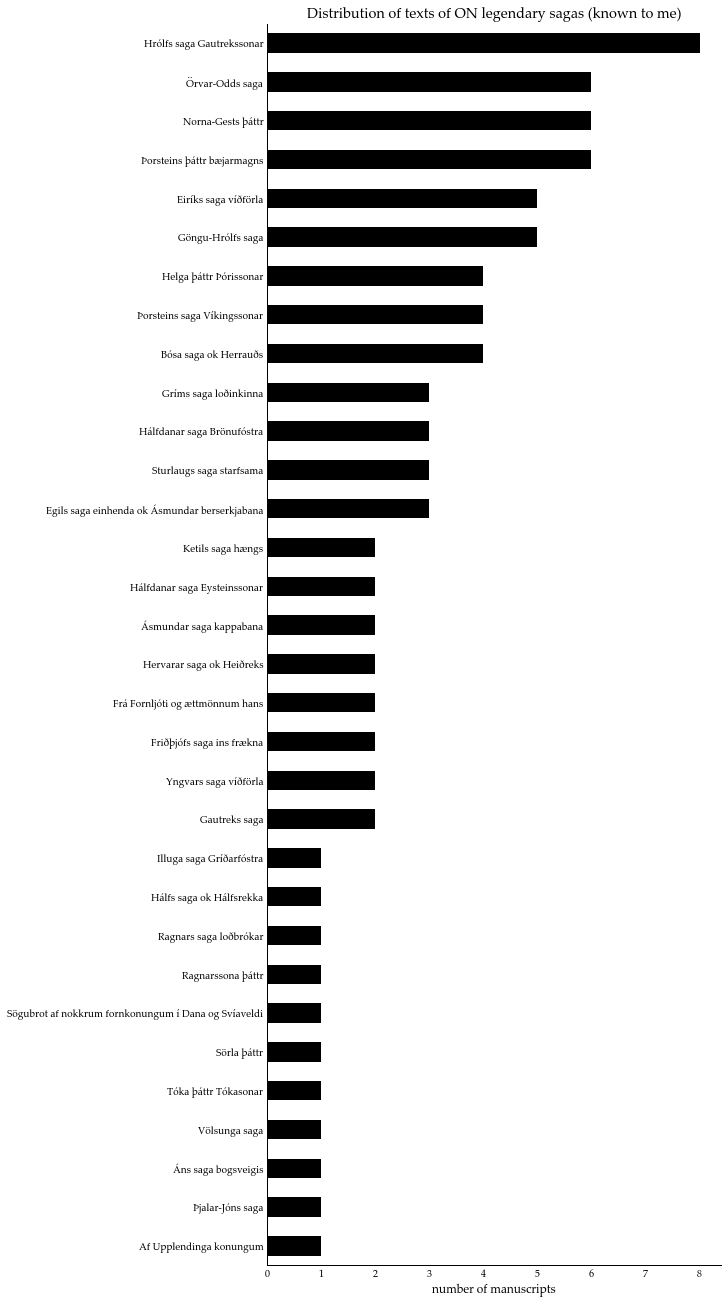

In [4]:
fig, ax = plt.subplots(figsize=(10,18))
mnl.groupby('text').size().sort_values(ascending=True).plot.barh(ax=ax);
ax.set(xlabel='number of manuscripts', ylabel='', 
       title='Distribution of texts of ON legendary sagas (known to me)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('output/Fig1.jpeg', dpi=300, transparent=True)

Yet a different perspective is to list the size of the frequency bins that we can distinguish within the manuscript counts:

In [5]:
types = mnl.groupby('text').size().sort_values(ascending=False).value_counts().sort_index()
types = types.to_frame(name='aantal teksten')
types['aantal handschriften'] = types.index
types.to_excel('output/Tab1.xlsx')
types

,aantal teksten,aantal handschriften
1,11,1
2,8,2
3,4,3
4,3,4
5,2,5
6,3,6
8,1,8


Finally, we define the auxiliary function `species_richness` to count the number of unique texts in the data (i.e. the number of non-zero counts):

In [6]:
def species_richness(counts):
    return np.sum(counts > 0)

print('# unique texts:', species_richness(mnl.groupby('text').size()))
print('# witnesses:', len(mnl))

# unique texts: 32
# witnesses: 87


## Jackknife

The following function computes the first-order Jackknife estimate, on the basis of the abundance data in our data frame, as well as a confidence interval (.95 be default). This approach is detailed in the following paper:

> K. Burnham & W. Overton, "Robust Estimation of Population Size When Capture Probabilities Vary Among Animals". *Ecology* (1979), 927-936.

In [7]:
def jackknife(data, conf_lvl=0.95):
    jack_stat = species_richness(data)
    
    x = np.array(sum([[i] * c for i, c in enumerate(data, 1)], []))
    index = np.arange(x.shape[0])
    
    vals = []
    for i in range(x.shape[0]):
        t = x[index != i]
        vals.append(species_richness(np.bincount(t)))
    
    mean_jack_stat = np.mean(vals)
    bias = (x.shape[0] - 1) * (mean_jack_stat - jack_stat)
    
    estimate = jack_stat - bias
    
    std_err = np.sqrt(
        (x.shape[0] - 1) * 
        np.mean((mean_jack_stat - vals) * 
                (mean_jack_stat - vals), axis=0)
    )    
    
    z_score = np.sqrt(2.0) * erfinv(conf_lvl)
    conf_interval = estimate + z_score * np.array((-std_err, std_err))
    
    return estimate, std_err, conf_interval

results = jackknife(mnl.groupby('text').size())
print('jackknife-estimate (order=1):', results[0], results[-1])

jackknife-estimate (order=1): 42.873563218390935 [36.83294758 48.91417886]


This implementation is verbose and uses an explicit `for`-loop, which iteratively leaves out observations and tracks the drops in diversity that follow from this operation. In the code blocks below we show that the same estimate can also be obtained in a fully analytical fashion. First we calculate the frequency counts for each unique text:

In [8]:
num_per_text = mnl.groupby('text').size()
num_per_text

text
Af Upplendinga konungum                                 1
Bósa saga ok Herrauðs                                   4
Egils saga einhenda ok Ásmundar berserkjabana           3
Eiríks saga víðförla                                    5
Friðþjófs saga ins frækna                               2
Frá Fornljóti og ættmönnum hans                         2
Gautreks saga                                           2
Gríms saga loðinkinna                                   3
Göngu-Hrólfs saga                                       5
Helga þáttr Þórissonar                                  4
Hervarar saga ok Heiðreks                               2
Hrólfs saga Gautrekssonar                               8
Hálfdanar saga Brönufóstra                              3
Hálfdanar saga Eysteinssonar                            2
Hálfs saga ok Hálfsrekka                                1
Illuga saga Gríðarfóstra                                1
Ketils saga hængs                                       2
Norna-Ges

Next, we store the species richness (the number of unique texts) in $t$:

In [9]:
t = species_richness(num_per_text)
t

32

Then we set $s$ to the number of texts that are only attested in a single witness:

In [10]:
s = sum(num_per_text == 1)
s

11

Only the $s$ texts that occur once will affect the species richness during the iterative Jackknife procedure. We can therefore predict that we will obtain the following deviations when applying the bootstrap:

In [11]:
mu = (((t - s) * t) + (s * (t - 1))) / t
mu

31.65625

That means that we can calculate the bias as follows:

In [12]:
bias = (t - 1) * (mu - t)
bias

-10.65625

To account for this bias, we can subtract it from the original species richness in the observed data:

In [13]:
t - bias

42.65625

## Simple example

In [14]:
counts = [5, 4, 3, 3, 1, 1, 1, 1, 1]
names = 'ABCDEFGHI'
data = zip(counts, names)
df = pd.DataFrame(zip(names, counts), columns=('naam', 'mss'))
df.to_excel('output/Tab2.xlsx')
df

,naam,mss
0,A,5
1,B,4
2,C,3
3,D,3
4,E,1
5,F,1
6,G,1
7,H,1
8,I,1


In [15]:
print('total # of witnesses:', df['mss'].sum())

total # of witnesses: 20


In [16]:
species_richness(df['mss'])

9

In [17]:
jackknife(df['mss'])

(13.75, 1.8874586088176875, array([10.0506491, 17.4493509]))

In [18]:
data = np.array(df['mss'])
x = np.array(sum([[i]*c for i, c in enumerate(data, 1)], []))
tradition = [names[i - 1] for i in x]
print(tradition)

['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'D', 'D', 'D', 'E', 'F', 'G', 'H', 'I']


In [19]:
bootstrap = []
for i in range(len(tradition)):
    tradition_ = [tradition[j] for j in range(len(tradition)) if i != j]
    
    bootstrap.append((
        (i + 1), tradition[i], ''.join(tradition_),
        len(set(tradition_)), len(set(tradition_)) - len(set(tradition))))

In [20]:
df = pd.DataFrame(bootstrap, columns=('iteration', 'leftout', 'imputed tradition', 'richness', 'error'))
df.to_excel('output/Tab3.xlsx')
df

,iteration,leftout,imputed tradition,richness,error
0,1,A,AAAABBBBCCCDDDEFGHI,9,0
1,2,A,AAAABBBBCCCDDDEFGHI,9,0
2,3,A,AAAABBBBCCCDDDEFGHI,9,0
3,4,A,AAAABBBBCCCDDDEFGHI,9,0
4,5,A,AAAABBBBCCCDDDEFGHI,9,0
5,6,B,AAAAABBBCCCDDDEFGHI,9,0
6,7,B,AAAAABBBCCCDDDEFGHI,9,0
7,8,B,AAAAABBBCCCDDDEFGHI,9,0
8,9,B,AAAAABBBCCCDDDEFGHI,9,0
9,10,C,AAAAABBBBCCDDDEFGHI,9,0


In [21]:
mean_estimate = np.mean(df['richness'])
print('Average estimate:', mean_estimate)
print('Bias:', mean_estimate - 9)

Average estimate: 8.75
Bias: -0.25


In [22]:
bias = 19 * (mean_estimate - 9)
bias

-4.75

In [23]:
corrected = 9 - bias
corrected

13.75

In [24]:
conf_lvl = .95

std_err = np.sqrt(
    19 * np.mean((mean_estimate - df['richness']) * 
                 (mean_estimate - df['richness']), axis=0))
    
z_score = np.sqrt(2.0) * erfinv(conf_lvl)
conf_interval = corrected + z_score * np.array((-std_err, std_err))
conf_interval

array([10.0506491, 17.4493509])

## Chao1

In the paper we eventually opt for the more recent, non-parametric formula "Chao1", which is described in this paper:

> A. Chao & L. Jost, ‘Estimating diversity and entropy profiles via discovery rates of new species". *Methods in Ecology and Evolution* (2015), 873-882.

Because we have "doubletons" in our data, we use can the following formula, where:
- $\hat{f_0}$ is the (theoretical) number of non-observed species/texts;
- $f_1$ is the number of species/texts attested exactly once ("singletons");
- $f_2$ is the number of species/texts attested exactly twice ("doubletons");
- $n$ is the total number of individuals/manuscripts in the observed data.

\begin{equation}
\hat{f_0} = \frac{(n - 1)}{n} \frac{f_1^2}{2f_2}
\end{equation}

The code block below returns the full, theoretical species richness as etimated by Chao1, i.e. it adds the estimated $\hat{f_0}$ to the species richness that was observed in the sample:

In [25]:
def chao_richness(x):
    x, n = x[x > 0], x.sum()
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    return t + (n - 1) / n * ((f1 ** 2 / 2 / f2) if f2 > 0 else (f1 * (f1 - 1) / 2))

If we apply this function to our data, we obtain an even higher (but arguably more realistic) estimate of the loss in textual diversity for this literature. Note, however, that this estimate is still a theoretical *minimum estimate*, since the original loss could still be higher.

In [26]:
chao_richness(num_per_text)

39.47557471264368

Instead of reporting just this number, we apply a bootstrapped procedure in which we sample from the material using a multinomial distribution (see the Appendix Chao and Jost, 2015) and apply Chao1 to the resulting samples. This procedure allows us to calculate a .95 confidence interval for this value.

In [27]:
def bt_prob(x):
    x, n = x[x > 0], x.sum()
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    C = 1 - f1 / n * (((n - 1) * f1 / ((n - 1) * f1 + 2 * f2)) if f2 > 0 else
                      ((n - 1) * (f1 - 1) / ((n - 1) * (f1 - 1) + 2)) if f1 > 0 else
                      0)
    W = (1 - C) / np.sum(x / n * (1 - x / n) ** n)
    p = x / n * (1 - W * (1 - x / n) ** n)
    f0 = np.ceil(((n - 1) / n * f1 ** 2 / (2 * f2)) if f2 > 0 else
                 ((n - 1) / n * f1 * (f1 - 1) / 2))
    p0 = (1 - C) / f0
    p = np.hstack((p, np.array([p0 for i in np.arange(f0)])))
    return p


def bootstrap(x, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    pro = np.array([chao_richness(row) for row in data_bt])
    
    pro_mean = pro.mean(0)
    
    lci_pro = -np.quantile(pro, (1 - conf) / 2, axis=0) + pro_mean
    uci_pro = np.quantile(pro, 1 - (1 - conf) / 2, axis=0) - pro_mean

    sd_pro = np.std(pro, axis=0)

    pro = pro_mean - pro
    return (lci_pro, uci_pro, sd_pro, pro)

In [28]:
def chao_estimate(x, n_iter=1000, conf=0.95):
    pro = chao_richness(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

The following block applies this bootstrapped procedure to obtain the final estimates:

In [29]:
lci_pro, uci_pro, bt_pro, pro = chao_estimate(num_per_text, n_iter=10000)
print('pro:', pro)
print('lci_pro:', lci_pro)
print('uci_pro:', uci_pro)

pro: 39.47557471264368
lci_pro: 28.554685801360193
uci_pro: 63.66962833009582


The array `bt_pro` contains the estimates that were collected during the bootstrap (1,000 iterations by default). Below, we plot the distribution of these numbers using a rainplot: [removing rain_alpha =.3 argument on pt.RainCloud() because it is showing as invalid]

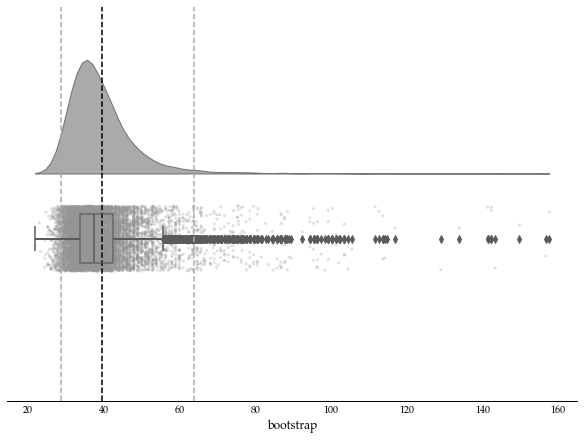

In [30]:
import ptitprince as pt

fig, ax = plt.subplots(figsize=(8, 6))

d = list([(x, 'bootstrap') for x in bt_pro])
bt = pd.DataFrame(d, columns=('bootstrap', 'type'))

pt.RainCloud(
    data=bt, x="type", y="bootstrap", ax=ax, 
    orient="h", alpha=.8, bw=.2, rain_alpha=.3, palette="Greys"
)
ax.axvline(pro, c='black', ls='--')
ax.axvline(uci_pro, c='darkgrey', ls='--')
ax.axvline(lci_pro, c='darkgrey', ls='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_ylabel('')
plt.savefig('output/Fig2.png', dpi=300, transparent=True)

[These findings refer to the original study of Dutch romances and have not yet been analyzed for the FAS] The idea that there were at least 100 texts is not completely unlikely, but it is a very
conservative estimate, at the very bottom of the probability continuum. The estimate of ~148 manuscripts (or more) is much more plausible, which would mean that *at least half of
the chivalric texts have been lost*.  Just as 100 is an extremely optimistic
estimate, ~219 is the most pessimistic estimate: in that
case, only a third of the ever available chivalric epics would have been persisted through
time, which is quite a dramatic, but not entirely unrealistic figure.

## Species accumulation curve

In what preceded, we have investigated how many unique texts may have been lost, or, more positively, how many unique texts we may have not yet seen. In this concluding section, we investigate how many texts should be retrieved before we arrive at this diversity estimate. This new estimate provides us with information about the total population size, i.e. the total number of text witnesses. We follow Hsieh, Ma and Chao (2016) to compute this estimate using "Rarefaction Extrapolation". For details about this method, see:

> Hsieh, Ma and Chao (2016): iNEXT: an R package for rarefaction and extrapolation ofspecies diversity. *Methods in Ecology and Evolution*, 7, 1451–1456.

In [31]:
def bootstrap_re(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    Dq = fn(x)
    
    pro = np.array([fn(row) for row in data_bt])
    
    error = stats.norm.ppf(1 - (1 - conf) / 2) * np.std(pro, 0)
    lci_pro = Dq - error
    uci_pro = Dq + error

    sd_pro = np.std(pro, axis=0)

    return (lci_pro, uci_pro, sd_pro, Dq, )


def rarefaction_extrapolation(x, max_steps):
    x, n = x[x > 0], x.sum()
    def _sub(m):
        if m <= n:
            return np.sum(1 - np.array(
                [np.exp(gammaln(n - i + 1) + gammaln(n - m + 1) - 
                        gammaln(n - i - m + 1) - gammaln(n + 1)) if i <= (n - m) else
                 0 for i in x]))
        else:
            S = (x > 0).sum()
            f1, f2 = (x == 1).sum(), (x == 2).sum()
            f0 = ((n - 1) / n * f1 * (f1 - 1) / 2) if f2 == 0 else ((n - 1) / n * f1**2 / 2 / f2)
            A = n * f0 / (n * f0 + f1)
            return S if f1 == 0 else (S + f0 * (1 - A**(m - n)))
    return np.array([_sub(mi) for mi in range(1, max_steps)])

In [32]:
counts = np.bincount(mnl.groupby('text').size())[1:] # ignore zero
x = np.array(sum([[i] * c for i, c in enumerate(counts, 1)], []))

Here too we use a bootstrap method with 100 samples:

In [33]:
max_steps = 1000
lci_pro, uci_pro, sd_pro, Dq = bootstrap_re(
    x, 
    fn=partial(rarefaction_extrapolation, max_steps=max_steps), 
    n_iter=100
)

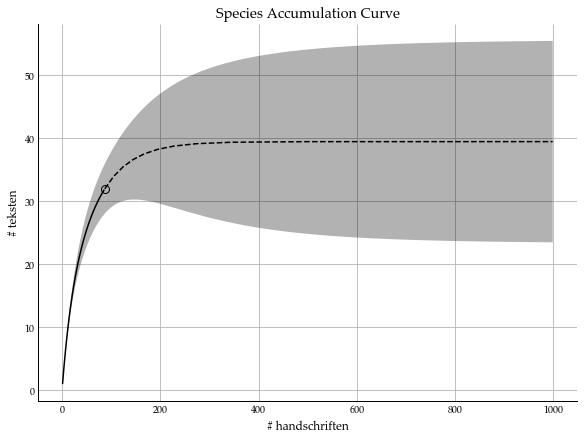

In [34]:
steps = np.arange(1, max_steps)
interpolated = np.arange(1, max_steps) < x.sum()

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(steps[interpolated], Dq[interpolated], color='C0')
ax.plot(x.sum(), Dq[x.sum() - 1], 'o')
ax.plot(steps[~interpolated], Dq[~interpolated], '--', color='C0')
ax.fill_between(steps, lci_pro, uci_pro, alpha=0.3)
ax.grid()
ax.set(xlabel='# handschriften', ylabel='# teksten', title='Species Accumulation Curve')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('output/Fig3.png', dpi=300, transparent=True)

This graph would suggest a rough estimate of 39 works and 200-300 witnesses. However the graph forms a significantly different shape than the original study and requires closer scrutiny.
